In [1]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from time import time
import pickle

In [2]:
def load(path_imag):
    data = loadmat(path_imag)
    return data['X'], data['y']

#path = "/Users/adbb271/Downloads/OneDrive_1_04-11-2019"
#path = "/Users/willemvandemierop/Documents/Master AI/Programming and Mathematics for AI/Coursework"
path = "/Users/damie/OneDrive - City, University of London/INM702"

filename_read_train = os.path.join(path, "train_32x32.mat")
filename_read_test = os.path.join(path,"test_32x32.mat")

X_train, y_train = load(filename_read_train)
print(X_train[0].shape)
X_test, y_test = load(filename_read_test)

y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

#plot_door_numbers(X_train,y_train,2,8)

#plot_door_numbers(X_test,y_test, 2,8)

lr = np.arange(10)
for label in range(10):
    one_hot = (lr==label).astype(np.int)
    #print("label: ", label, " in one-hot representation: ", one_hot)

no_of_different_labels = 10
lr = np.arange(no_of_different_labels)

fac = 0.99 / 255
add_fac = 0.01

X_train = np.asfarray(X_train[:,:]) * fac + add_fac
X_test = np.asfarray(X_test[:, :]) *fac + add_fac

train_labels_one_hot = (lr == y_train).astype(np.float)
test_labels_one_hot = (lr == y_test).astype(np.float)

#print(train_labels_one_hot[2])

print("\n X train shape", X_train.shape)
X_train_reshaped = X_train.reshape(32*32*3,73257)
print("X train reshaped", X_train_reshaped.shape)
print(" X test shape", X_test.shape)
X_test_reshaped = X_test.reshape(32*32*3,26032)
print("X test reshaped", X_test_reshaped.shape)

print("\n Data loaded correctly and reshaped")

os.system('say "Data Loaded correctly"')


(32, 3, 73257)

 X train shape (32, 32, 3, 73257)
X train reshaped (3072, 73257)
 X test shape (32, 32, 3, 26032)
X test reshaped (3072, 26032)

 Data loaded correctly and reshaped


1

In [3]:
def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


@np.vectorize
def ReLU(weight_times_data):
    return np.maximum(0.0, weight_times_data)


# derivation of relu
def ReLU_derivation(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def stable_softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)


In [4]:
class NeuralNetwork:

    def __init__(self,
                 network_structure,
                 learning_rate, active_percentage,
                 bias=None):
        self.accuracy_val_list = None
        self.val_loss_list = None
        self.loss_list = None
        self.accuracy_list = None
        self.output_list = None
        self.before_acti_list = None
        self.epochs_list = None
        self.structure = network_structure
        self.learning_rate = learning_rate
        self.bias = bias
        self.active_percentage = active_percentage
        self.create_weight_matrices()
        self.number_of_layers = len(self.structure)


    def create_weight_matrices(self):
        self.weight_matrices = []
        layer_network_index = 1
        number_of_layers = len(self.structure)
        self.before_acti_list = []
        self.output_list = []
        self.accuracy_val_list = []
        self.val_loss_list = []
        self.loss_list = []
        self.accuracy_list = []
        self.epochs_list = []
        for i in range(number_of_layers - 1):
            self.before_acti_list.append(0)
            self.output_list.append(0)
        while layer_network_index < number_of_layers:
            nodes_in = self.structure[layer_network_index - 1]
            nodes_out = self.structure[layer_network_index]
            rad = 1 / np.sqrt(nodes_in)
            n = nodes_in * nodes_out
            X = truncated_normal(mean=2, sd=1, low= -rad, upp=rad)
            temp_weight_matrix = X.rvs(n).reshape((nodes_out, nodes_in))
            self.weight_matrices.append(temp_weight_matrix)
            layer_network_index += 1

    def dropout_weight_matrices(self):
        self.orig_weight_matrices = self.weight_matrices.copy()
        self.orig_structure = self.structure.copy()

        active_nodes = []
        active_indices = []

        layer_index = 0
        self.number_of_layers = len(self.structure)
        #creates the active indices
        while layer_index < self.number_of_layers - 1:
            temp_active_nodes = int(self.structure[layer_index]*self.active_percentage)
            active_nodes.append(temp_active_nodes)
            temp_active_indices = sorted(random.sample(range(0, self.structure[layer_index]), temp_active_nodes))
            active_indices.append(temp_active_indices)
            self.structure[layer_index] = active_nodes[layer_index]
            layer_index += 1
        #changes the shapes of the weight matrices
        layer_index = 0
        number_of_layers = self.number_of_layers - 1
        while layer_index < number_of_layers:
            if layer_index == number_of_layers - 1:
                self.weight_matrices[layer_index] = self.weight_matrices[layer_index][:,active_indices[layer_index]]
                layer_index += 1
            else:
                self.weight_matrices[layer_index] = self.weight_matrices[layer_index][:, active_indices[layer_index]][active_indices[layer_index+1]]
                layer_index += 1
        return active_indices


    def weight_matrices_reset(self,active_indices):
        layer_index = 0
        if(self.active_percentage == 1):
            self.weight_matrices = self.weight_matrices
            self.structure = self.structure
        else:
            while layer_index < self.number_of_layers - 2:
                temp_active_indices = active_indices[layer_index]
                temp = self.weight_matrices[layer_index].copy()
                temp = temp[:, temp_active_indices]
                temp[active_indices[layer_index+1]] = self.weight_matrices[layer_index]
                self.orig_weight_matrices[layer_index][:,active_indices[layer_index]] = temp
                self.weight_matrices[layer_index] = self.orig_weight_matrices[layer_index].copy()
                layer_index += 1
            self.orig_weight_matrices[self.number_of_layers - 2][: , active_indices[self.number_of_layers - 2]] = self.weight_matrices[self.number_of_layers - 2]
            self.weight_matrices[self.number_of_layers - 2] = self.orig_weight_matrices[self.number_of_layers - 2].copy()

            self.structure = self.orig_structure.copy()


    def forward_update(self, input_vector):
        input_vector = np.array(input_vector,ndmin = 2).T
        layer_index = 0
        while layer_index < self.number_of_layers -2:
            #print("layer index", layer_index)
            #print("weight matrix shape", np.shape(self.weight_matrices[layer_index]))
            before_activation = np.dot(self.weight_matrices[layer_index], input_vector)/self.active_percentage
            input_vector = ReLU(before_activation)
            self.before_acti_list[layer_index] = before_activation
            self.output_list[layer_index] = input_vector
            layer_index+=1
        
        #print("len of first weightmatrix", np.shape(self.weight_matrices[0]))
        #print("len of second weightmatrix", np.shape(self.weight_matrices[1]))
        #print("len of third weightmatrix", np.shape(self.weight_matrices[2]))
        
        #print("layer index", layer_index)
        #print("weight matrix shape", np.shape(self.weight_matrices[layer_index]))
        
        before_activation = np.dot(self.weight_matrices[layer_index], input_vector)
        input_vector = stable_softmax(before_activation)
        self.before_acti_list[layer_index] = before_activation
        self.output_list[layer_index] = input_vector

    #backward only Relu
    def backward(self,target, input_vector):
               
        target = np.array(target,ndmin=2).T
        output_network = self.output_list[-1]
        error = np.array(target - output_network)
        no_of_layers = self.number_of_layers - 1
        
        #print("no of layers", no_of_layers)
         
        
        for layer in range(no_of_layers - 1, -1, -1):
            
            #adding if statement for softmax, if not using softmax comment this if statement out and use below code

            
            if layer == no_of_layers - 1:
                derivative_output = np.array(output_network - target)
                temp = derivative_output
            else:
                derivative_output = ReLU_derivation((self.output_list[layer]))
                temp = error * derivative_output
                
            error = np.dot(self.weight_matrices[layer].T, temp)
            #print("error2", np.shape(error))
            if layer ==  0:
                prev_layer = np.array(input_vector,ndmin=2).T
            else:
                prev_layer = np.array(self.output_list[layer-1])
            dE = np.dot(temp, prev_layer.T)
            if layer == no_of_layers - 1:
                self.weight_matrices[layer] -= self.learning_rate*dE  
            else:
                self.weight_matrices[layer] -= self.learning_rate*dE
            
            #if no softmax use below code and comment out above if statement
            '''
            #print("layer", layer )
            #print("error", np.shape(error))
            derivative_output = ReLU_derivation((self.output_list[layer]))
            #print("derivative output shape",np.shape(derivative_output))
            temp = error * derivative_output
            error = np.dot(self.weight_matrices[layer].T, temp)
            #print("error2", np.shape(error))
            if layer ==  0:
                prev_layer = np.array(input_vector,ndmin=2).T
            else:
                prev_layer = np.array(self.output_list[layer-1])
            dE = np.dot(temp, prev_layer.T)
            self.weight_matrices[layer] += self.learning_rate*dE
            '''
            

    def forward(self, input_vector):
        input_vector = np.array(input_vector).T
        layer_index = 0
        while layer_index < self.number_of_layers - 2:
            
            before_activation = np.dot(self.weight_matrices[layer_index], input_vector)
            input_vector = ReLU(before_activation)
            layer_index += 1

        before_activation = np.dot(self.weight_matrices[layer_index], input_vector)
        input_vector = stable_softmax(before_activation)

        return input_vector
    
    def run(self, X, one_hot, y, val_x, val_one_hot, val_y, epochs, Fast = False):
        initial_time = time()
        
        
        
        for epoch in range(epochs):
            time_epoch = time()
            self.epochs_list.append(epoch)
            pretty_print = 0
            print("Epoch: ", epoch)
            #corrects, wrongs = 0,0
            for i in range(len(X[1])):
                #for i in range(start, start + 1):
                if (i // 2000) == pretty_print:
                    if pretty_print == (len(X[1])//4000):
                        print('$',end = '') #indicate halfway
                    else:
                        print('*', end = '')
                    pretty_print += 1
                
                inpt_vector = np.array(X[:,i]).T

                self.forward_update(inpt_vector)

                self.backward(target = one_hot[i], input_vector = inpt_vector)
            #self.weight_matrices_reset(active_indices)
            if Fast == False:
                self.get_accuracies(X,one_hot,y,val_x,val_one_hot, val_y)
                print("\nTrain accuracy: ", round(self.accuracy_list[-1],2), "%")
                print("Test accuracy: ", round(self.accuracy_val_list[-1],2), "%")
            
            print("Time trained epoch = ", round((time() - time_epoch)/60,2), "min")
        print("\nTotal Time trained = ", round((time() - initial_time)/60,2), "min")


    def get_accuracies(self, X, one_hot, y, val_x, val_one_hot, val_y):
        corrects,wrongs = 0,0
        loss_sum = 0
        for i in range(len(X[1])):
        #for i in range(100):
            vector = self.forward(X[:, i])

            vector_max = vector.argmax()
            
            loss_sum += (y[i] - vector_max)**2
            if vector_max == y[i]:
                corrects += 1
            else:
                wrongs += 1
                
                
        loss = (loss_sum)/len(X[1])
                                
        Accuracy = (corrects / (corrects + wrongs)) * 100
        self.loss_list.append(loss)
        self.accuracy_list.append(Accuracy)
        
        print("Corrects", corrects)
        print("Wrongs", wrongs)
        print("Accuracy", Accuracy)
        print("Len X[1]", len(X[1]))
        corrects_val = 0
        wrongs_val = 0
        loss_sum_val = 0
        for j in range(len(val_x[1])):
        #for j in range(100):
            vector = self.forward(val_x[:, j])
            
            vector_max = vector.argmax()
            
            loss_sum_val += (val_y[j] - vector_max)
            
            if vector_max == val_y[j]:
                corrects_val += 1
            else:
                wrongs_val += 1
                                
        val_loss = (loss_sum_val)/len(val_x[1])
                                
        Accuracy_val = (corrects_val / (corrects_val + wrongs_val)) * 100
        self.val_loss_list.append(val_loss)
        self.accuracy_val_list.append(Accuracy_val)
        
    def return_lists(self):
        return self.accuracy_list, self.loss_list, self.accuracy_val_list, self.val_loss_list, self.epochs_list



In [20]:
#now we implement a way to save our networks, carefull overwriting prev models. 

network_name = "NN_two_hidden_new_loss11"
overwrite = True


image_pixels = 32*32*3
structure = [image_pixels,300,150,75,10]
LR = 0.001
dropout_percentage = 0.7

if(os.path.exists(path + network_name)) == False or overwrite:
    if (os.path.exists(path + network_name)):
        print("you are creating a model that already exists, overwriting model!")
    
    network = NeuralNetwork(network_structure = structure,
                        learning_rate = LR, active_percentage = dropout_percentage)
    
    Pickle_file = open(path + network_name, 'wb')
    network_data = {'Neural_network' : network, 'Epoch': 0, 'Trained_epochs':[],'Train_accuracy_list': [],
                   'Test_accuracy_list': [], 'Loss_List_train': [], 'Loss_List_test': []}
    pickle.dump(network_data,Pickle_file)
    Pickle_file.close()
    print("Neural network initialised and saved")
else:
    print("Failed to initialise bc network already exists and overwrite = False")
    

Neural network initialised and saved


In [21]:
# train already saved neural network in this section

#open from pickle file
network_name = "NN_two_hidden_new_loss11"
Pickle_file = open(path + network_name, 'rb')
network_data = pickle.load(Pickle_file)
Pickle_file.close()

#Train the network
network = network_data['Neural_network']
epoch = network_data['Epoch']
Trained_epoch = network_data['Trained_epochs']
trained_acc_list = network_data['Train_accuracy_list']
test_acc_list = network_data['Test_accuracy_list']
trained_loss_list = network_data['Loss_List_train']
test_loss_list = network_data['Loss_List_test']


epochs = 10
network.run(X = X_train_reshaped, one_hot = train_labels_one_hot, y = y_train,val_x = X_test_reshaped, val_one_hot = test_labels_one_hot, val_y = y_test, epochs = epochs, Fast = False)

os.system('say "Finished training"')

acc_list,loss_list,acc_list_val,loss_list_val,epochs_list = network.return_lists()

trained_acc_list = acc_list
trained_loss_list = loss_list
test_acc_list = acc_list_val
test_loss_list = loss_list_val
trained_epochs = epochs_list
epoch = trained_epochs[-1]


#save the network
network_data = {'Neural_network' : network, 'Epoch': epoch, 'Trained_epochs': trained_epochs,'Train_accuracy_list': trained_acc_list,
                   'Test_accuracy_list': test_acc_list, 'Loss_List_train': trained_loss_list, 'Loss_List_test': test_loss_list}

Pickle_file = open(path + network_name, 'wb')
pickle.dump(network_data, Pickle_file)
Pickle_file.close()


Epoch:  0
******************$******************Corrects 35064
Wrongs 38193
Accuracy 47.86436791023384
Len X[1] 73257

Train accuracy:  47.86 %
Test accuracy:  45.2 %
Time trained epoch =  16.92 min
Epoch:  1
******************$******************Corrects 45724
Wrongs 27533
Accuracy 62.41587834609662
Len X[1] 73257

Train accuracy:  62.42 %
Test accuracy:  59.19 %
Time trained epoch =  16.91 min
Epoch:  2
******************$******************Corrects 49845
Wrongs 23412
Accuracy 68.04127933166797
Len X[1] 73257

Train accuracy:  68.04 %
Test accuracy:  63.88 %
Time trained epoch =  16.87 min
Epoch:  3
******************$******************Corrects 52376
Wrongs 20881
Accuracy 71.49623926723726
Len X[1] 73257

Train accuracy:  71.5 %
Test accuracy:  67.91 %
Time trained epoch =  16.86 min
Epoch:  4
******************$******************Corrects 53978
Wrongs 19279
Accuracy 73.68306100440914
Len X[1] 73257

Train accuracy:  73.68 %
Test accuracy:  69.61 %
Time trained epoch =  16.79 min
Epoch: 

Train accuracy:  73.75 %
Test accuracy:  69.83 %
Number of Epochs trained: 9


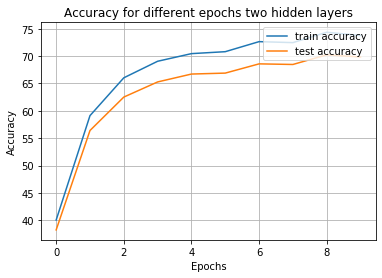

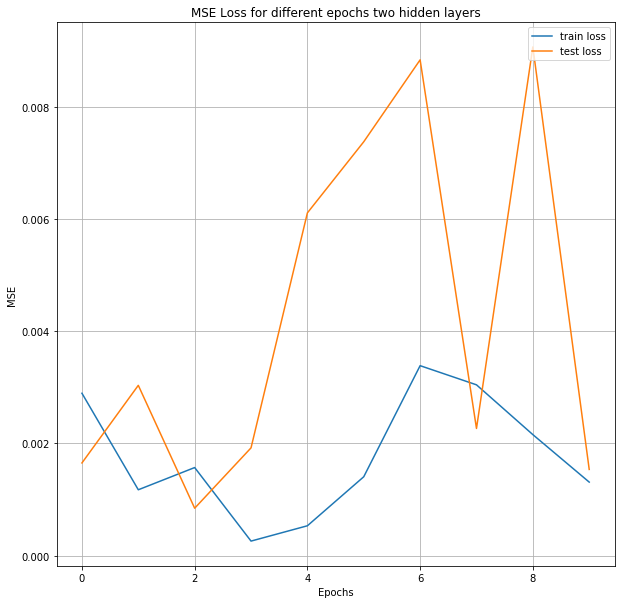

In [28]:
#loading from pickle
network_name = "NN_two_hidden_new_loss6"
Pickle_file = open(path + network_name, 'rb')
network_data = pickle.load(Pickle_file)
Pickle_file.close()

network = network_data['Neural_network']
epoch = network_data['Epoch']
Trained_epoch = network_data['Trained_epochs']
trained_acc_list = network_data['Train_accuracy_list']
test_acc_list = network_data['Test_accuracy_list']
trained_loss_list = network_data['Loss_List_train']
test_loss_list = network_data['Loss_List_test']

epochs_list = []
for i in range(0, len(trained_acc_list)):
    epochs_list.append(i)

print("Train accuracy: ", round(trained_acc_list[-1],2), "%")
print("Test accuracy: ", round(test_acc_list[-1],2), "%")
print("Number of Epochs trained:", epochs_list[-1])

plt.plot(epochs_list,trained_acc_list, label = "train accuracy")
plt.plot(epochs_list,test_acc_list, label = "test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy for different epochs two hidden layers')
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('ArbitrarlynetworkACC.png')

fig = plt.figure(figsize=(10,10))      
plt.plot(epochs_list,trained_loss_list, label = "train loss")
plt.plot(epochs_list,test_loss_list, label = "test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title('MSE Loss for different epochs two hidden layers')
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('ArbitrarlynetworkLoss.png')